In [1]:
%load_ext line_profiler
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import pickle

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

import multiprocessing as mp
from multiprocessing import Pool

import warnings
warnings.filterwarnings('error')

In [2]:
records=pd.read_csv('data/ydata-fp-td-clicks-v2_0.20111005', 
                    sep=' ',
                    names=['timestamp','id','clicked'],
                    usecols=[0,1,2],)

In [3]:
records.head()

,timestamp,id,clicked
0,1317772490,id-570650,0
1,1317772491,id-570332,0
2,1317772492,id-568437,0
3,1317772492,id-571362,0
4,1317772492,id-568890,0


In [4]:
records.tail()

,timestamp,id,clicked
1373872,1317858893,id-575230,0
1373873,1317858893,id-575157,0
1373874,1317858893,id-575000,0
1373875,1317858893,id-572306,0
1373876,1317858893,id-575115,0


In [5]:
with open('save/lifespans','rb') as f:
    lifespans = pickle.load(f)

24 1317830699 1317783600 13.083055555555555


51

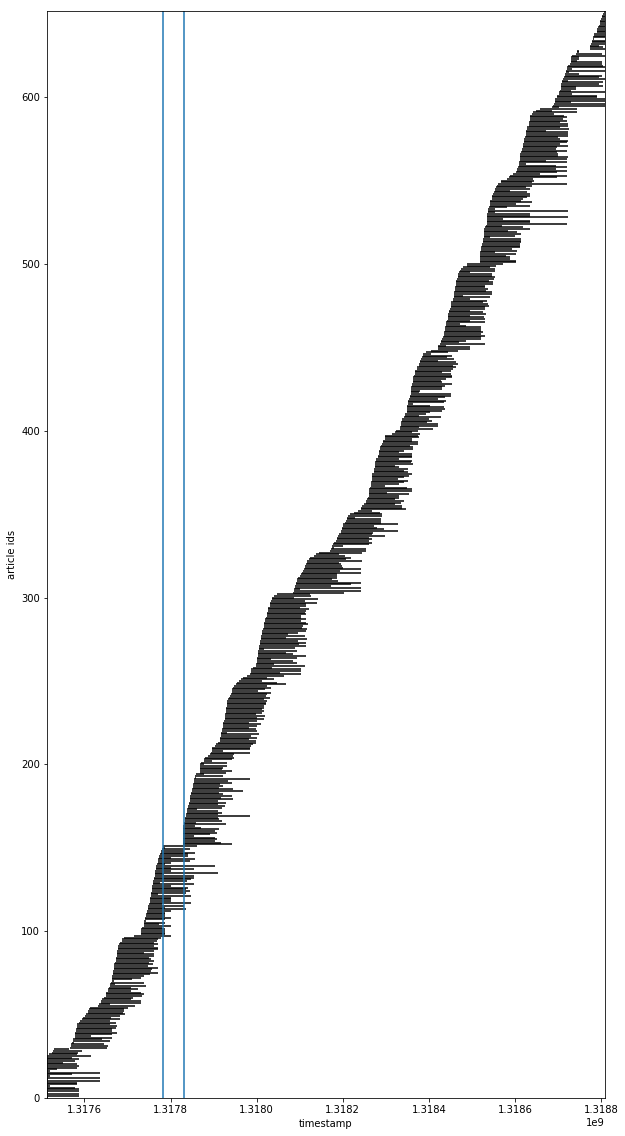

In [6]:
plt.figure(figsize=(10,20))
y=0
for start,stop in lifespans.values():
    plt.hlines(y, xmin=start, xmax=stop)
    #plt.scatter(np.arange(start,stop,1000),[y for j in range(start,stop,1000)], marker='.')
    y+=1
plt.xlabel('timestamp')
plt.ylabel('article ids')
plt.xlim(1317513291, 1318809293)
plt.ylim(0,652)

l=[] # min heap with items like: (stop, start, arm)
global_max=0
for i in lifespans.items():
    arm=i[0]
    start,stop=i[1]
    while l and l[0][0]<start:
        heapq.heappop(l)
        if len(l)>=24:
            min_stop=l[0][0]
            max_start=max(l, key=lambda i:i[1])[1]
            if min_stop-max_start>=3600*12:
                plt.axvline(min_stop)
                plt.axvline(max_start)
                pool=[i[2] for i in l]
                print(len(l), min_stop, max_start, (min_stop-max_start)/3600)
    heapq.heappush(l,(stop,start,arm)) # min stop (earliest expiring)
    
    global_max=max(global_max, len(l))
global_max

In [7]:
start=records[records.timestamp==1317783600].index[0]
stop=records[records.timestamp==1317830699].index[-1]
slice=records.iloc[start:stop+1]
slice.head()

,timestamp,id,clicked
350160,1317783600,id-572194,0
350161,1317783600,id-572582,0
350162,1317783600,id-569364,0
350163,1317783600,id-569270,0
350164,1317783600,id-573053,0


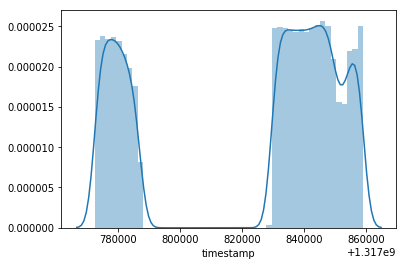

In [9]:
sns.distplot(records.timestamp)

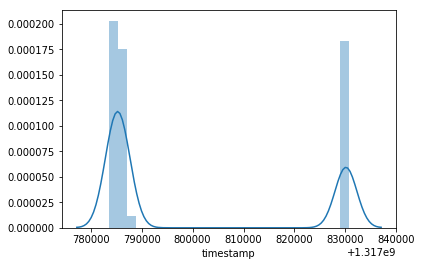

In [10]:
sns.distplot(slice.timestamp)

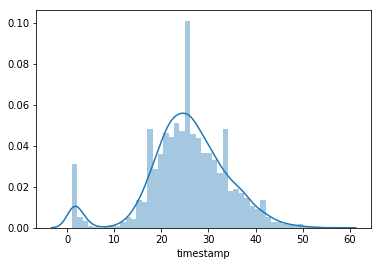

In [8]:
sns.distplot(slice.timestamp.value_counts())

In [11]:
slice.timestamp.value_counts().describe()

count    5038.000000
mean       25.570266
std         8.608354
min         1.000000
25%        21.000000
50%        26.000000
75%        31.000000
max        57.000000
Name: timestamp, dtype: float64

In [112]:
def form_bins(t):
    ts=slice.timestamp//t*t
    ts.value_counts().sort_index().plot()
    plt.xlabel('timestamp')
    plt.ylabel('G(t)')
    #plt.xlim(right=1317787250)
    
    plt.figure()
    sns.distplot(ts.value_counts())
    plt.xlabel('G(t)')
    print(ts.value_counts().describe())

count    5038.000000
mean       25.570266
std         8.608354
min         1.000000
25%        21.000000
50%        26.000000
75%        31.000000
max        57.000000
Name: timestamp, dtype: float64


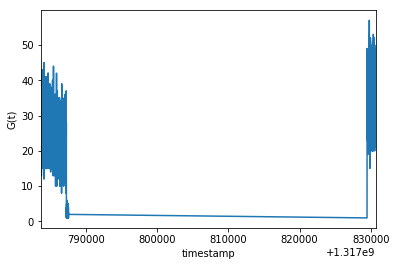

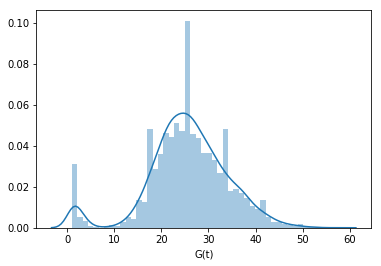

In [115]:
form_bins(1)

In [116]:
timestamp30=slice.timestamp//30*30
records30=slice.copy()
records30.timestamp=timestamp30
records30

,timestamp,id,clicked
350160,1317783600,id-572194,0
350161,1317783600,id-572582,0
350162,1317783600,id-569364,0
350163,1317783600,id-569270,0
350164,1317783600,id-573053,0
350165,1317783600,id-568437,0
350166,1317783600,id-569065,0
350167,1317783600,id-571705,0
350168,1317783600,id-572582,0
350169,1317783600,id-570846,0


In [202]:
slice

,timestamp,id,clicked
350160,1317783600,id-572194,0
350161,1317783600,id-572582,0
350162,1317783600,id-569364,0
350163,1317783600,id-569270,0
350164,1317783600,id-573053,0
350165,1317783600,id-568437,0
350166,1317783600,id-569065,0
350167,1317783600,id-571705,0
350168,1317783600,id-572582,0
350169,1317783600,id-570846,0


In [36]:
class Arm:
    def __init__(self):
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{:.4f} {}/{}'.format(self.X, self.rewards, self.T)

In [22]:
lifespans

{'id-552077': [1317513291, 1317515399],
 'id-555224': [1317513291, 1317588299],
 'id-555528': [1317513291, 1317587099],
 'id-559744': [1317513291, 1317515699],
 'id-559855': [1317513291, 1317587099],
 'id-560290': [1317513291, 1317587099],
 'id-560518': [1317513291, 1317578399],
 'id-560620': [1317513291, 1317521099],
 'id-563115': [1317513291, 1317581999],
 'id-563582': [1317513291, 1317583799],
 'id-563643': [1317513291, 1317636599],
 'id-563787': [1317513291, 1317515699],
 'id-563846': [1317513291, 1317636599],
 'id-563938': [1317513291, 1317519299],
 'id-564335': [1317513291, 1317571199],
 'id-564418': [1317513291, 1317636599],
 'id-564604': [1317513291, 1317520799],
 'id-565364': [1317513291, 1317535499],
 'id-565479': [1317513291, 1317583499],
 'id-565515': [1317513291, 1317587399],
 'id-565533': [1317513291, 1317583499],
 'id-565561': [1317513291, 1317549899],
 'id-565589': [1317513291, 1317577499],
 'id-565648': [1317513291, 1317586799],
 'id-565747': [1317513291, 1317570299],


In [ ]:
class Arm:
    def __init__(self,lifespan):
        self.birth, self.death = lifespan
        self.s = None
        self.l = None
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{:.4f} {}/{} lifespan: {}'.format(self.X, self.rewards, self.T, (self.birth, self.death, self.s, self.l))

In [ ]:
pool = {}
for k in lifespans:
    pool[k] = Arm(lifespans[k])
unborn = list(sorted(pool.keys(), key=lambda k:pool[k].birth, reverse=True)) # list of unborn arms sorted by birth descendingly


In [50]:
G=records.timestamp.value_counts()

In [51]:
G.describe()

count    44342.000000
mean        30.983650
std          7.401837
min          1.000000
25%         26.000000
50%         31.000000
75%         36.000000
max         63.000000
Name: timestamp, dtype: float64

In [41]:
class Epsilon_z_greedy:
    def __init__(self, records=records, G=G):
        self.alive = []
        self.G_ = Counter() # actual G(t) computed during playing
        self.records = records.itertuples() # optimal speed, sub-optimal space
        self.rewards = 0
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.G = G # estimation of G(t) counted from records
        self.best = None
        
    def update(self, record):
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        if not self.best:
            self.best = record.id
        else:
            self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
    
    def filter_live(self, time):
        '''
        edit list of currently available arms
        '''
        # bisect module in Python doesn't support keys
        # implement my own bisect function that use .death as key
        def bisect_by_death(value):
            l = 0
            h = len(self.alive)
            while l < h:
                m = (l + h) // 2
                arm = self.alive[m]
                if self.pool[arm].death < value:
                    l = m + 1
                else:
                    h = m
            return l
        # drop dead arms
        index = bisect_by_death(time)
        self.alive = self.alive[ index : ]
        # pop new born arms to 'alive'
        # keep popping from 'unborn' until every born arm goes to 'alive'
        # arms in 'unborn' are sorted by birth in descending order
        # so the youngest arm is at the end of array
        while self.unborn and self.pool[self.unborn[-1]].birth<=time:
            arm = self.unborn.pop()
            # insert this arm to correct position in 'alive'(sorted by death)
            index = bisect_by_death(self.pool[arm].death)
            self.alive.insert(index, arm)
    
    def initialize(self, m=24):
        i=0
        while i<m:
            record = next(self.records) # raise StopIteration
            filter_live(record.timestamp)
            if self.pool[record.id].T==0: # not played
                self.G_[record.timestamp] += 1
                self.update(record)
                i+=1
    
    def play(self, n, m=24, z=36):
        c=Counter()
        es=[]
        
        prev_time = None
        prev_pick = None
        bin_reward = 0
        k=250 # k>4/(best.X-2ndBest.X)
        t_ = 0 # number of rounds under the threshold z up to time t
        
        t=0
        while t<n:
            record = next(self.records) # raise StopIteration
            
            time = record.timestamp
            self.filter_live(time)
            if record.timestamp == prev_time: # still in the last time bin
                pick = prev_pick # lock recommendation
            else: # entering a new time bin
                # accumulate bin reward
                if bin_reward != 0: # last time bin is valid
                    t+=1
                    self.rewards += bin_reward/self.G_[prev_time]*self.G[prev_time]
                bin_reward = 0
                
                if z!=None: # epsilon-z greedy
                    epsilon = 1 if t_==0 else min(1, k*m/t_)
                    #es.append(epsilon)
                    if self.G[record.timestamp]<z:
                        t_ += 1
                        if random.random()<epsilon:
                            pick = random.choice(self.alive)
                        else:
                            pick = self.best
                    else:
                        pick = self.best
                        
                else: # vallina epsilon greedy
                    epsilon = min(1, k*m/(t+25))
                    if random.random()<epsilon:
                        pick = random.choice(self.alive)
                    else:
                        pick = self.best

            if pick == record.id: # historical action matches proposed action
                self.G_[record.timestamp] += 1
                bin_reward += record.clicked
                self.update(record)
                
            prev_pick = pick
            prev_time = record.timestamp
        # accumulate last bin reward
        if bin_reward !=0:
            self.rewards += bin_reward/self.G_[prev_time]*self.G[prev_time]
        print(c)
        #plt.plot(es)

In [46]:
ezg = Epsilon_z_greedy()
ezg.initialize()
ezg.play(10000,z=None)
ezg.rewards

Counter({'invalid record': 1342568, 'lock mismatch': 1299213, 'explore': 44339, 'invalid bin': 43141, 'lock match': 30290})


28489.083333333332

In [47]:
ezg = Epsilon_z_greedy()
ezg.initialize()
ezg.play(10000)
ezg.rewards

Counter({'invalid record': 1342539, 'lock mismatch': 1299190, 'invalid bin': 42387, 'lock match': 30313, '>=z mismatch': 23544, '<z explore mismatch': 13014, '<z exploit': 6939, '<z exploit mismatch': 6791, '>=z match': 544, '<z explore match': 298, '<z exploit match': 148})


47025.95000000001

In [86]:
class UCB_z:
    def __init__(self, records=records, pool=pool, G=records.timestamp.value_counts()):
        self.alive = [] # heap: (death, id)
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.X = 0        
        self.G_ = Counter() # actual G(t) computed during playing
        self.records = records.itertuples() # optimal speed, sub-optimal space
        self.rewards = 0
        self.G = G # estimation of G(t) counted from records
        self.best = None
        
    def update(self, record):
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        self.rewards += record.clicked
        n_seen = len(self.pool) - len(self.unborn)
        self.X = (self.X * (n_seen-1) + record.clicked) / n_seen
        if not self.best:
            self.best = record.id
        else:
            self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
    
    def filter_live(self, time):  
        # pop born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=time:
            arm = self.unborn.pop()
            heapq.heappush(self.alive, (self.pool[arm].death, arm))
        # pop dead arms from alive
        while self.alive:
            death, arm = self.alive[0]
            if death < time:
                heapq.heappop(self.alive)
                dying = self.pool[arm]
                n_dead = len(self.pool) - len(self.unborn) - len(self.alive)
            else:
                break
                
    def initialize(self, m=24):
        i=0
        while i<m:
            record = next(self.records) # raise StopIteration
            self.filter_live(record.timestamp)
            if self.pool[record.id].T==0: # not played
                self.G_[record.timestamp] += 1
                self.update(record)
                i+=1
    
    def play(self, n, z=36):
        c=Counter()
        def score(heap_tuple):
            arm = self.pool[heap_tuple[1]]
            if not arm.T: # new arm
                return float('inf')
            arm = self.pool[heap_tuple[1]]
            return arm.X + np.sqrt(2*np.log(t)/arm.T) 

        prev_time = None
        prev_pick = None
        bin_reward = 0
        t=24
        while t<n:
            record = next(self.records) # raise StopIteration    
            time = record.timestamp
            self.filter_live(time)
            # deciding "the pick"
            if time == prev_time: # still in the last time bin
                pick = prev_pick # lock recommendation
            else: # entering a new time bin
                # accumulate bin reward
                if bin_reward != 0: # accumulate reward if last time bin is valid
                    t += 1
                    self.rewards += bin_reward/self.G_[prev_time]*self.G[prev_time]
                bin_reward = 0
                
                if z != None: # UCB-z
                    if self.G[record.timestamp]<z:
                        c['<z']+=1
                        pick = max(self.alive, key=score)[1]
                    else:
                        c['>=z']+=1
                        pick = self.best
                        alter = max(self.alive, key=score)[1]
                        if pick!=alter:
                            if pick==record.id and record.clicked:
                                c['good']+=1
                            if alter==record.id and record.clicked:
                                c['bad']+=1
                else:
                    pick = max(self.alive, key=score)[1]
                    
            if pick == record.id: # historical action matches proposed action
                self.G_[record.timestamp] += 1
                bin_reward += record.clicked
                self.update(record)
                    
            prev_pick = pick
            prev_time = record.timestamp
        # accumulate last bin reward
        if bin_reward !=0:
            self.rewards += bin_reward/self.G_[prev_time]*self.G[prev_time]
        print(c)

In [87]:
ucbz = UCB_z()
ucbz.initialize()
ucbz.play(1000)
ucbz.rewards

Counter({'<z': 21043, '>=z': 8302, 'good': 17, 'bad': 1})


24988.154761904756

In [74]:
ucbz = UCB_z()
ucbz.initialize()
ucbz.play(1000,z=None)
ucbz.rewards

Counter()


24608.391666666674

(1317783600.0, 1317787250)

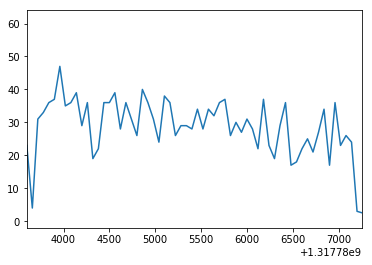

In [40]:
pd.Series(ezg.G_).plot()
plt.xlim(right=1317787250)

In [48]:
l1=[]
l2=[]
for i in range(100):
    ezg = Epsilon_z_greedy()
    ezg.initialize()
    ezg.play(10000)
    l1.append(ezg.rewards)

    ezg2 = Epsilon_z_greedy()
    ezg2.initialize()
    ezg2.play(10000, z=None) # vallina epsilon
    l2.append(ezg2.rewards)
    
    #print(i, end='\r', flush=True)

Counter({'invalid record': 1342819, 'lock mismatch': 1299476, 'invalid bin': 42340, 'lock match': 30027, '>=z mismatch': 23546, '<z explore mismatch': 12994, '<z exploit': 6955, '<z exploit mismatch': 6803, '>=z match': 542, '<z explore match': 302, '<z exploit match': 152})
Counter({'invalid record': 1343044, 'lock mismatch': 1299692, 'explore': 44339, 'invalid bin': 43168, 'lock match': 29811})
Counter({'invalid record': 1344602, 'lock mismatch': 1301220, 'invalid bin': 42410, 'lock match': 28283, '>=z mismatch': 23555, '<z explore mismatch': 12998, '<z exploit': 6964, '<z exploit mismatch': 6829, '>=z match': 533, '<z explore match': 289, '<z exploit match': 135})
Counter({'invalid record': 1342672, 'lock mismatch': 1299341, 'explore': 44339, 'invalid bin': 43153, 'lock match': 30162})
Counter({'invalid record': 1343812, 'lock mismatch': 1300506, 'invalid bin': 42258, 'lock match': 28997, '>=z mismatch': 23534, '<z explore mismatch': 12963, '<z exploit': 6967, '<z exploit mismatch':

Counter({'invalid record': 1342852, 'lock mismatch': 1299497, 'explore': 44339, 'invalid bin': 43220, 'lock match': 30006})
Counter({'invalid record': 1342826, 'lock mismatch': 1299504, 'invalid bin': 42402, 'lock match': 29999, '>=z mismatch': 23504, '<z explore mismatch': 12953, '<z exploit': 7012, '<z exploit mismatch': 6865, '>=z match': 584, '<z explore match': 286, '<z exploit match': 147})
Counter({'invalid record': 1342760, 'lock mismatch': 1299380, 'explore': 44339, 'invalid bin': 43156, 'lock match': 30123})
Counter({'invalid record': 1342799, 'lock mismatch': 1299467, 'invalid bin': 42160, 'lock match': 30036, '>=z mismatch': 23511, '<z explore mismatch': 12990, '<z exploit': 6977, '<z exploit mismatch': 6831, '>=z match': 577, '<z explore match': 284, '<z exploit match': 146})
Counter({'invalid record': 1342625, 'lock mismatch': 1299294, 'explore': 44339, 'invalid bin': 43149, 'lock match': 30209})
Counter({'invalid record': 1344036, 'lock mismatch': 1300651, 'invalid bin':

Counter({'invalid record': 1343209, 'lock mismatch': 1299832, 'explore': 44339, 'invalid bin': 43200, 'lock match': 29671})
Counter({'invalid record': 1343412, 'lock mismatch': 1300079, 'invalid bin': 42324, 'lock match': 29424, '>=z mismatch': 23538, '<z explore mismatch': 13039, '<z exploit': 6918, '<z exploit mismatch': 6756, '>=z match': 550, '<z explore match': 294, '<z exploit match': 162})
Counter({'invalid record': 1343029, 'lock mismatch': 1299680, 'explore': 44339, 'invalid bin': 43175, 'lock match': 29823})
Counter({'invalid record': 1343282, 'lock mismatch': 1299930, 'invalid bin': 42353, 'lock match': 29573, '>=z mismatch': 23546, '<z explore mismatch': 12994, '<z exploit': 6955, '<z exploit mismatch': 6812, '>=z match': 542, '<z explore match': 302, '<z exploit match': 143})
Counter({'invalid record': 1342691, 'lock mismatch': 1299408, 'explore': 44339, 'invalid bin': 43129, 'lock match': 30095})
Counter({'invalid record': 1343662, 'lock mismatch': 1300312, 'invalid bin':

Counter({'invalid record': 1342859, 'lock mismatch': 1299554, 'explore': 44339, 'invalid bin': 43119, 'lock match': 29949})
Counter({'invalid record': 1343096, 'lock mismatch': 1299715, 'invalid bin': 42265, 'lock match': 29788, '>=z mismatch': 23545, '<z explore mismatch': 13035, '<z exploit': 6943, '<z exploit mismatch': 6801, '>=z match': 543, '<z explore match': 273, '<z exploit match': 142})
Counter({'invalid record': 1342795, 'lock mismatch': 1299474, 'explore': 44339, 'invalid bin': 43137, 'lock match': 30029})
Counter({'invalid record': 1343364, 'lock mismatch': 1299998, 'invalid bin': 42235, 'lock match': 29505, '>=z mismatch': 23574, '<z explore mismatch': 13014, '<z exploit': 6961, '<z exploit mismatch': 6778, '>=z match': 514, '<z explore match': 276, '<z exploit match': 183})
Counter({'invalid record': 1342639, 'lock mismatch': 1299356, 'explore': 44339, 'invalid bin': 43163, 'lock match': 30147})
Counter({'invalid record': 1343454, 'lock mismatch': 1300076, 'invalid bin':

Counter({'invalid record': 1342928, 'lock mismatch': 1299579, 'explore': 44339, 'invalid bin': 43122, 'lock match': 29924})
Counter({'invalid record': 1343154, 'lock mismatch': 1299758, 'invalid bin': 42358, 'lock match': 29745, '>=z mismatch': 23548, '<z explore mismatch': 13049, '<z exploit': 6941, '<z exploit mismatch': 6799, '>=z match': 540, '<z explore match': 261, '<z exploit match': 142})
Counter({'invalid record': 1342774, 'lock mismatch': 1299356, 'explore': 44339, 'invalid bin': 43172, 'lock match': 30147})
Counter({'invalid record': 1343036, 'lock mismatch': 1299712, 'invalid bin': 42261, 'lock match': 29791, '>=z mismatch': 23531, '<z explore mismatch': 13027, '<z exploit': 6941, '<z exploit mismatch': 6766, '>=z match': 557, '<z explore match': 283, '<z exploit match': 175})
Counter({'invalid record': 1342936, 'lock mismatch': 1299594, 'explore': 44339, 'invalid bin': 43130, 'lock match': 29909})
Counter({'invalid record': 1343068, 'lock mismatch': 1299709, 'invalid bin':

Text(0.5, 1.0, 'reward distributions')

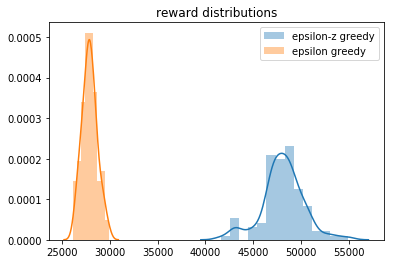

In [49]:
sns.distplot(l1, label='epsilon-z greedy')
sns.distplot(l2, label='epsilon greedy')
plt.legend()
plt.title('reward distributions')

In [264]:
l3=[]
for i in range(100):
    ezg3 = Epsilon_z_greedy()
    ezg3.initialize()
    ezg3.play(2000)
    l3.append(ezg3.rewards)

Text(0.5, 1.0, 'reward distributions')

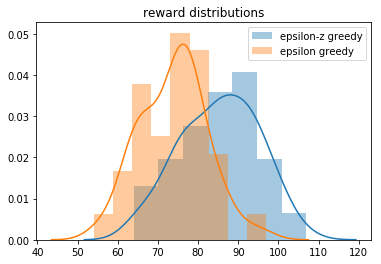

In [265]:
sns.distplot(l3, label='epsilon-z greedy')
sns.distplot(l2, label='epsilon greedy')
plt.legend()
plt.title('reward distributions')

In [48]:
from scipy.stats import ttest_ind

In [323]:
ttest_ind(l3,l2)

Ttest_indResult(statistic=8.954170552891155, pvalue=2.511963777284569e-16)